In [1]:
import json
import pandas as pd
from pprint import pprint
from collections import Counter, defaultdict
from itertools import chain
import re

import arrow 

import googlemaps

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.figure_factory as ff
import plotly.graph_objs as go

import cufflinks as cf

import spacy
import scattertext as st
from scattertext import word_similarity_explorer

from gender import GenderDetector

In [2]:
nlp = spacy.load('en')

In [3]:
init_notebook_mode(connected=True)

In [4]:
class T:
    
    def __init__(self):
        
        """
        collected TripAdvisor data comes as JSONs; this class does some data processing including imputation
        """

        self.r = json.load(open('data/reviews_brisbane.json'))
        self.u = json.load(open('data/users_brisbane.json'))
        self.a = json.load(open('data/attractions_brisbane.json'))  

        # convert everything to pandas
        
        self.u_df = pd.DataFrame(self.u).dropna(subset=['name'])
        self.r_df = pd.DataFrame(self.r).dropna(subset=['attr_id'])
              
        self.u_all_tags = [tg for tg in chain.from_iterable(self.u_df['tags'])]
        self.tag_cols = list(set(self.u_all_tags))
              
        self.gmaps = googlemaps.Client(key=open('creds/geocoding_api.key').readline().strip())
        
        self.gd = GenderDetector()
    
    def stats(self):
        
        self.user_stats = defaultdict(list)
        
        self.review_ids = set()
        self.attr_ids = set()
        self.user_names = set()
        self.dates_exp = set()
        
        for r in self.r:
            
            self.review_ids.add(r['id'])
            self.attr_ids.add(r['attr_id'])
            self.user_names.add(r['by_user'])
            
            if r['date_of_experience']:
                self.dates_exp.add(arrow.get(r['date_of_experience'], 'MM/YYYY'))
        
        print(f'DATA\n{"".join(["-"]*4)}')
        print('{:,} reviews written between {} and {} for {:,} attractions by {:,} users' \
                  .format(len(self.review_ids), 
                          min(self.dates_exp).format("MM/YYYY"), 
                          max(self.dates_exp).format("MM/YYYY"), 
                          len(self.attr_ids), 
                          len(self.user_names)))
        
        for u in self.u:
            for attr in 'tags age gender name'.split():   
                if u[attr]:
                    self.user_stats[attr].append(u[attr])
        
        print('user attribute availability:')
        print(' ~ '.join(['{}: {:,} ({:.1f})%'.format(attr, 
                                                    len(self.user_stats[attr]), 
                                                    100*len(self.user_stats[attr])/len(self.user_stats['name'])) 
                                                       for attr in 'tags age gender'.split()]))
              
        return self
        
    def _tags_to_cols(self, tag_list):
        
        if not tag_list:
            return [None]*len(self.tag_cols)
        
        return ['yes' if tag in tag_list else 'no' for tag in self.tag_cols]
    
    def tags_to_cols(self):
        
        self.u_df = pd.concat([self.u_df, 
                            pd.DataFrame(self.u_df['tags'].apply(self._tags_to_cols).to_list(), 
                                         columns=self.tag_cols)], axis=1).drop('tags', axis=1)
        
        return self

              
    def _fix_location(self, s):
              
        """
        using Google Geocoding API to clarify users location
        """
        
        loc = dict()
        
        if not (isinstance(s, str) and s.strip()):
            print('geocoding API needs a string argument!')
            return loc
        
        geocode_result = self.gmaps.geocode(s)
        
        # take only the top result
        if geocode_result:
            res = geocode_result[0]
        else:
            print(f'geocoding api can\'t find this location: {s}!')
            return loc
        
        if 'address_components' in res:
            for _ in res['address_components']:
                if 'country' in _['types']:
                    loc.update({'country': _['long_name']})
                if 'locality' in _['types']:
                    loc.update({'locality': _['long_name']})
        if 'formatted_address' in res:
            loc.update({'location': res['formatted_address']})
        
        try:
            loc.update({'coordinates': res['geometry']['location']})
        except:
            pass
        
        if not loc:
            print('locationd fields couldn\'t be retrieved from geocoding result!')
                               
        return loc

    
    def impute_location(self):
        
        self.countries = {_['name'].lower() for _ in json.load(open('data/countries.json'))}
              
        localities = []
        countries = []
    
        c_geo = 0
        
        for i, row in enumerate(self.u_df.iterrows(), 1):
                               
            users_country = None
              
            if isinstance(row[1].location, str):
              
                loc_str = ' '.join(re.sub(r'[\-\_]', ' ', row[1].location).split()).lower()

                _found_countries = set()

                for country in self.countries:
                    if ' ' + country + ' ' in ' ' + loc_str + ' ':
                        _found_countries.add(country.title())

                if len(_found_countries) == 1:
                    users_country = _found_countries.pop()
                else:
                  # run geolocation
                  r = self._fix_location(loc_str)
                  c_geo += 1
              
                  if 'country' in r:
                     users_country = r['country']
            
            print(f'#{i}: location: {row[1].location} -> country: {users_country}')
            
            countries.append(users_country)
                               
        self.u_df['country'] = countries
              
        print(f'ran geolocation {c_geo} times ({100*c_geo/len(self.u_df):.1f}%)')
        
        return self
    
    def _impute_gender(self, s):
        
        # separate nicknames like TrevorJ into trevor J; or Mike23 into Mike 23
        s = re.sub(r'([a-z]{1})([A-Z0-9]+)', r'\1 \2', s)
        
        return self.gd.gender(s)
    
    def impute_gender(self):
        
        self.u_df['gender'] = self.u_df['gender'] \
                                .apply(lambda s: s if str(s) in 'm f'.split() else self._impute_gender(str(s)))
        return self
    
    def merge_data(self):
        
        self.data = self.r_df.join(self.u_df.set_index('name'), on='by_user', how='inner')
        self.data.to_csv('data/brisb.csv', index=False)
        
        return self
    
    def selector(self, dk):

        if not (set(dk) <= set(t.data.columns)):
            print('wrong segments!')
            raise Exception()
        
        out = t.data
    
        for k in dk:
            out = out[out[k] == dk[k]]
        
        if not out.empty:
            return out
        else:
            print('empty result!')
            raise Exception()

In [ ]:
if __name__ == '__main__':
    
    t = T().stats().tags_to_cols().merge_data()

In [37]:
# t.u_df.to_csv('u_countries.csv', index=False)

In [5]:
df = pd.read_csv('brisb.csv.gz')

In [6]:
df.head(2)

,attr_id,by_user,date_of_experience,date_of_writing,id,rating,text,title,age,gender,...,60+ traveller,art and architecture lover,vegetarian,thrill seeker,beach goer,shopping fanatic,backpacker,eco-tourist,trendsetter,country
0,d256511,Gilliebean63,07/2018,13/02/2019,651830536,5.0,"Easy access by bus, or a boat which leaves fro...",Koala's and kangaroos,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Australia
1,d256511,Rob I,02/2019,13/02/2019,651820141,4.0,This is a nice little place to visit and the s...,Nice place but poor Koalas,50-64,m,...,no,no,no,no,no,no,no,no,no,United Kingdom


In [14]:
# spacy corpus
docs = [nlp(review) for review in df.text.tolist()]

In [15]:
ents = [d.ents for d in docs]

In [16]:
ents[:12]

[(Southbank, Koala, 20),
 (Koala, Koalas, hundred),
 (Australian,),
 (Koala,),
 (22 years ago, one, one),
 (),
 (CBD, Australian, Kangaroo, the afternoon, The Sheep Dog Show),
 (about 7 miles,
  Brisbane,
  first,
  1927,
  130,
  100,
  Australian,
  about $20,
  US,
  early in the morning,
  up to 30 minutes,
  Tasmanian Devil,
  early in the morning,
  daily 9am to 5pm),
 (Lone Pine Koala Sanctuary, Australian, Ranger, a few seconds, Lone Pine),
 (),
 (9 to 9:30 am, Koala, 25,-, AUD, Kanguru, 2$),
 (Koala, Roo)]

In [ ]:
# NER separately
from spacy.pipeline import EntityRecognizer

In [7]:
df1 = df[['text', 'gender']].fillna('unknown')

In [8]:
df1.head()

,text,gender
0,"Easy access by bus, or a boat which leaves fro...",unknown
1,This is a nice little place to visit and the s...,m
2,Great park-zoo with all the Australian animals...,unknown
3,You can even have your photo taken with a Koal...,unknown
4,I last visited this place 22 years ago and it ...,unknown


In [9]:
corpus = st.CorpusFromPandas(df1, category_col='gender', text_col='text', nlp=nlp).build()

In [10]:
# term frequency data frame; note that terms become index!
term_freq_df = corpus.get_term_freq_df()

In [13]:
term_freq_df.head()

,unknown freq,m freq,f freq,male_score,female_score,unknown_score
term,,,,,,
easy,1258,260,408,0.053869,0.937344,0.963074
access,360,63,78,0.075965,0.028431,0.983081
by,1889,443,563,0.069082,0.923644,0.962597
bus,1164,278,398,0.067403,0.940747,0.034019
or,3960,804,1211,0.053514,0.930211,0.969894


In [14]:
term_freq_df.to_csv('word_freq.csv')

In [12]:
# get scaled f-scores for each term and place in new column
term_freq_df['male_score'] = corpus.get_scaled_f_scores('m')
term_freq_df['female_score'] = corpus.get_scaled_f_scores('f')
term_freq_df['unknown_score'] = corpus.get_scaled_f_scores('unknown')

In [72]:
html = st.produce_scattertext_explorer(corpus,
category='foodie',
category_name='Foodies',
not_category_name='Hist Buffs',
width_in_pixels=1000,
metadata=df_test['type'])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scattertext/frequencyreaders/DefaultBackgroundFrequencies.py:30: FutureWarning:

read_table is deprecated, use read_csv instead, passing sep='\t'.



In [73]:
open("foodies-historybuffs.html", 'wb').write(html.encode('utf-8'))

2219505

In [88]:
html = st.produce_scattertext_explorer(corpus, category='1', 
                                       category_name='Segment 1',  # for presentation only
                                       not_category_name='2',
                                       width_in_pixels=1000, 
                                       metadata=df['segment'])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scattertext/frequencyreaders/DefaultBackgroundFrequencies.py:30: FutureWarning:

read_table is deprecated, use read_csv instead, passing sep='\t'.



In [89]:
open("segs.html", 'wb').write(html.encode('utf-8'))

2027066

In [90]:
feat_builder = st.FeatsFromOnlyEmpath()

In [91]:
empath_corpus = st.CorpusFromParsedDocuments(df, 
                                             category_col='segment', 
                                             feats_from_spacy_doc=feat_builder, 
                                             parsed_col='text').build()

In [93]:
html = st.produce_scattertext_explorer(empath_corpus, 
                                       category='1', 
                                       category_name='Segment 1',
                                       not_category_name='Segment 2',
                                       width_in_pixels=1000,
                                       metadata=df['segment'],
                                       use_non_text_features=True,
                                       use_full_doc=True,
                                       topic_model_term_lists=feat_builder.get_top_model_term_lists())

In [94]:
open("segs_empath.html", 'wb').write(html.encode('utf-8'))

2409083

In [40]:
x_min = term_freq_df.male_score.min()
x_max = term_freq_df.male_score.max()
x_mean = term_freq_df.male_score.mean()

In [42]:
y_min = term_freq_df.female_score.min()
y_max = term_freq_df.female_score.max()
y_mean = term_freq_df.female_score.mean()

In [48]:
trace0 = go.Scatter(
    x = term_freq_df.iloc[:1000].male_score,
    y = term_freq_df.iloc[:1000].female_score,
    mode = 'markers',
    name = 'markers',
    text= term_freq_df.iloc[:1000].index
)

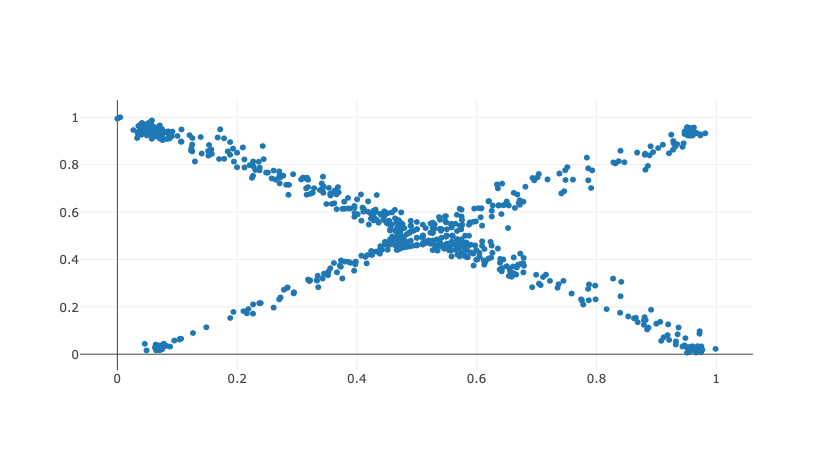

In [49]:
data = [trace0]
iplot(data)